# Training a Neural Network for Control Force Estimation

In this notebook, we train a Neural Network (NN) to estimate a control force function
$\textbf{f}(\textbf{p}_0,\textbf{p}_t,\textbf{w}): \mathbb{R}^{2\cdot2(O+U+T)+N}\to
\mathbb{R}^N$, that gives a force vector $\textbf{f} \in \mathbb{R}^N$ to be
applied at the current time step to move points $\textbf{p}_0$ to $\textbf{p}_t$ in the
next time step. Its inputs are the $(x,y)$ coordinates of $\textbf{p}_0$ and
$\textbf{p}_t$, as well as the basis coefficient vector $\textbf{w}$ at the current
time step concatenated after each other, giving $2\cdot2(O+U+T)+N$ values, where
$O$, $U$, and $T$ denote the number of overlapping, unique, and trivial sample
points, respectively.

**TODO**: Fix coloring of points for plotting. (This notebook ran an earlier version of PhiFlow, where PointClouds could be given a color property explicitly. This has to be refactored as in the other notebooks to color the points properly.)

### Uncomment this when Running in Colab

In [1]:
#!pip install --quiet phiflow==2.2.2
#import os
#if not os.path.isdir('eigenfluid-control'):
#  print("Cloning eigenfluid-control repo, this can take a moment")
#  os.system("git clone https://github.com/bobarna/eigenfluid-control")
#import sys; sys.path.append('eigenfluid-control')

## Imports & Initialization

In [1]:
from phi.torch.flow import *

from src.eigenfluid import Eigenfluid
from src.shapes import *

# Helper functions for visualization
from src.visu import *

import time

In [2]:
# Number of basis fields
N = 4**2
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
# NOT for sampling points, but for reconstructing the velocity grid
SAMPLING_SIZE = 32

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE, init_w='zero')
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 10.9771888256073 seconds


# Data

In [ ]:
# Get O overlapping, and U non-necessarily overlapping ('unique') sample points
O = 30
U = 40
N_S = O+U+5 # (5 trivial points)

# TRAIN_SIZE + VAL_SIZE = BATCH_SIZE
# For the overfitting example, set BATCH_SIZE=1, TRAIN_SIZE=1, VAL_SIZE=0, VISU_NR=1
BATCH_SIZE = 2000
TRAIN_SIZE = 1800
VAL_SIZE = 200
# Number of trajectories to visualize in the plots below
VISU_NR = 5

get_trivial_points = True

# Saving for visu purposes later on
shape_0_list = []
shape_t_list = []

def get_points_for_shapes(shape_0, shape_t):
    p_0 = shape_0.get_trivial_points()
    p_t = shape_target.get_trivial_points()
    if O != 0:
        sampler_union = ShapeSampler(shape_0, shape_t, N=O, h1=2, h2=7)
        p_0 = math.concat((p_0, sampler_union.p), instance('i'))
        p_t = math.concat((p_t, sampler_union.p), instance('i'))
    if U != 0:
        sampler_0 = ShapeSampler(shape_0, N=U, h1=3, h2=11)
        sampler_t = ShapeSampler(shape_t, N=U, h1=3, h2=11)
        # Concatenate both the union and non-union points
        p_0 = math.concat((p_0, sampler_0.p), instance('i'))
        p_t = math.concat((p_t, sampler_t.p), instance('i'))
    
    # Saving for visu purposes later on
    shape_0_list.append(shape_0)
    shape_t_list.append(shape_target)
    
    p_0 = shape_0.create_points(p_0)
    p_t = shape_target.create_points(p_t)
    
    return (p_0, p_t)

p_0_list = []
p_t_list = []
for i in range(BATCH_SIZE):
    # Circle / Square / Triangle
    Shape_0 = [Circle, Square, Triangle][np.random.randint(3)]
    Shape_target = [Circle, Square, Triangle][np.random.randint(3)]
    # Random positions [0,2.1] x [0,2.1]
    shape_0 = Shape_0(pos=(np.random.rand()*2.1, np.random.rand()*2.1))
    shape_target = Shape_target(pos=(np.random.rand()*2.1, np.random.rand()*2.1))
    
    p_0, p_t = get_points_for_shapes(shape_0, shape_target)
    p_0_list.append(p_0)
    p_t_list.append(p_t)

    
p_0 = math.stack(p_0_list, batch(batch=BATCH_SIZE))
p_t = math.stack(p_t_list, batch(batch=BATCH_SIZE))

In [5]:
# Generate transition data
STEPS = 16 #p_0 is at time step 1
p_trajectory = math.tensor([p_0+(p_t - p_0)/STEPS*t for t in range(STEPS)], batch('time') & p_0.shape)

p_vis = stack([p_0.batch[:VISU_NR], p_t.batch[:VISU_NR], p_trajectory.batch[:VISU_NR]], instance("points"))
COLOR = wrap(['blue', 'red', 'green'], instance(p_vis)["points"])

plot({
    "Blue: start shape\nRed: target shape\nGreen: trajectory": vis.overlay(
        PointCloud(p_visu, bounds=DOMAIN)
     )}, 
     animate='time',
     size=(12,4),
     color=COLOR
)

<Figure size 640x480 with 0 Axes>

# Loss Function

In [7]:
STEPS = 16 # Already defined during data generation
DT    = 0.2
VISCOSITY = 0.2

def to_model_flat(p_0, p_t, w):
    return math.concat([
        p_0['x'], p_0['y'],
        p_t['x'], p_t['y'],
        math.rename_dims(w, 'k', instance('i'))
    ], instance('i'))

def from_model_flat(net_output):
    return math.rename_dims(tensor(
        net_output,
        batch('batch') & channel('channels') & channel('vector')
    ).channels[0], 'vector', instance('k'))


@math.jit_compile
def loss_function(p_0, p_t, w):
    loss = 0
    p_est = p_0.time[0]
    p_est_traj = [p_est]
    w_traj = [w]
    for t in range(STEPS-1):
        # Feed data into NN to get CFE prediction
        model_input = to_model_flat(p_est, p_t.time[t], w)
        model_output = net(model_input.native('batch,channels,i'))
        f_pred = from_model_flat(model_output)
        #print("t={}, f_pred={}".format(t, f_pred))
        w += f_pred
        # Step simulation
        w = eigenfluid.step_w_euler(w, DT, viscosity=VISCOSITY)
        # Get velocities at p_0
        v_phi = eigenfluid.phi_template(w, eigenfluid.N, eigenfluid.basis_fields)
        p_velocities = v_phi(p_est)
        # Midpoint
        p_velocities = v_phi(p_est + p_velocities*DT/2)
        # Euler step for points
        p_est += p_velocities * DT
        p_est_traj.append(p_est)
        w_traj.append(w)
        loss += math.l2_loss(p_est - p_t.time[t])
        # Note: Estimated trajectory could be recalculated here based on new positions
    return loss, p_est_traj, w_traj
    

# Network and Training

In [8]:
# Input: [p_current, p_target, current_w]
# -> Input dimension = [O+U, O+U, N]
# Output = [N] force coefficients for current time step
#net = dense_net(2*2*(O+U)+N, N, [256, 128, 64, 32], batch_norm=True)
net = dense_net(N_S*2*2+N, N, [512, 256, 128, 64, 32])

print(net)
print("Number of parameters: {}".format(parameter_count(net)))
#print()
#print("Optimizer:{}".format(optimizer))

DenseNet(
  (linear0): Linear(in_features=316, out_features=512, bias=True)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=32, bias=True)
  (linear_out): Linear(in_features=32, out_features=16, bias=True)
)
Number of parameters: 337392


### Visualize Untrained CFE NN (first 5)

The NN is not yet trained at this point, and should just exert random forces.

In [9]:
## Test the loss function and the NN
loss, cfe_traj, _ = loss_function(
                    p_trajectory.time[0:STEPS-1].batch[:VISU_NR],
                    p_trajectory.time[1:STEPS].batch[:VISU_NR],
                    math.stack([eigenfluid.w]*VISU_NR, batch('batch'))
                )
print("Loss = {}".format(loss))
cfe_traj = math.stack(cfe_traj, batch('time'))
plot(PointCloud(cfe_traj, bounds=DOMAIN), animate='time')

/Users/bobarna/codes/phiflow/phi/torch/_torch_backend.py:524: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tuple([int(s) for s in tensor.shape])
/Users/bobarna/codes/phiflow/phi/torch/_torch_backend.py:54: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  tensor = torch.from_numpy(x)
/Users/bobarna/codes/phiflow/phi/math/_tensors.py:700: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might 

Loss = (174.407, 626.779, 47.675, 20.063, 674.848) along batchᵇ


<Figure size 640x480 with 0 Axes>

## Train

In [10]:
optimizer = adam(net)

start_time = time.time()

for epoch in range(261):
    w_optim = math.stack([eigenfluid.w]*TRAIN_SIZE, batch('batch'))
    loss, p_est_traj, _ = update_weights(net, optimizer, loss_function, 
                   p_trajectory.time[0:STEPS-1].batch[:TRAIN_SIZE], 
                   p_trajectory.time[1:STEPS].batch[:TRAIN_SIZE], 
                   w_optim)
    if epoch%5 == 0 or epoch < 5:
        # Get test loss
        val_loss, _, _ = loss_function(
            p_trajectory.time[0:STEPS-1].batch[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE],
            p_trajectory.time[1:STEPS].batch[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE],
            math.stack([eigenfluid.w]*VAL_SIZE, batch('batch'))
        )
        print("Optimization step {}, train loss: {}, val loss: {}".format(epoch, loss, val_loss))
        #print("Optimization step {}, train loss: {}".format(epoch, loss))

end_time = time.time()
print("Training finished in {} seconds".format(end_time-start_time))

/Users/bobarna/codes/phiflow/phi/torch/_torch_backend.py:524: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tuple([int(s) for s in tensor.shape])
/Users/bobarna/codes/phiflow/phi/torch/_torch_backend.py:54: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  tensor = torch.from_numpy(x)
/Users/bobarna/codes/phiflow/phi/math/_tensors.py:700: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might 

Optimization step 0, train loss: (batchᵇ=1800) 290.818 ± 227.364 (3e-01...1e+03), val loss: (batchᵇ=200) 264.049 ± 200.541 (5e+00...1e+03)
Optimization step 1, train loss: (batchᵇ=1800) 283.411 ± 220.293 (5e-01...1e+03), val loss: (batchᵇ=200) 258.423 ± 198.772 (9e+00...1e+03)
Optimization step 2, train loss: (batchᵇ=1800) 277.673 ± 212.711 (1e+00...1e+03), val loss: (batchᵇ=200) 260.344 ± 193.293 (1e+01...1e+03)
Optimization step 3, train loss: (batchᵇ=1800) 273.839 ± 211.245 (1e+00...1e+03), val loss: (batchᵇ=200) 250.756 ± 188.981 (9e+00...1e+03)
Optimization step 4, train loss: (batchᵇ=1800) 262.742 ± 195.962 (3e+00...1e+03), val loss: (batchᵇ=200) 245.328 ± 185.412 (9e+00...1e+03)
Optimization step 5, train loss: (batchᵇ=1800) 258.186 ± 186.092 (5e+00...1e+03), val loss: (batchᵇ=200) 236.675 ± 176.212 (1e+01...1e+03)
Optimization step 10, train loss: (batchᵇ=1800) 228.784 ± 157.017 (5e+00...1e+03), val loss: (batchᵇ=200) 212.068 ± 153.571 (2e+01...1e+03)
Optimization step 15, trai

Optimization step 195, train loss: (batchᵇ=1800) 37.502 ± 28.799 (9e-01...3e+02), val loss: (batchᵇ=200) 35.912 ± 30.694 (2e+00...2e+02)
Optimization step 200, train loss: (batchᵇ=1800) 37.175 ± 28.661 (9e-01...3e+02), val loss: (batchᵇ=200) 35.578 ± 30.599 (1e+00...2e+02)
Optimization step 205, train loss: (batchᵇ=1800) 37.074 ± 28.246 (7e-01...3e+02), val loss: (batchᵇ=200) 35.711 ± 30.324 (2e+00...2e+02)
Optimization step 210, train loss: (batchᵇ=1800) 40.194 ± 29.993 (3e+00...3e+02), val loss: (batchᵇ=200) 37.014 ± 31.490 (1e+00...3e+02)
Optimization step 215, train loss: (batchᵇ=1800) 37.811 ± 29.038 (2e+00...3e+02), val loss: (batchᵇ=200) 35.416 ± 29.833 (2e+00...2e+02)
Optimization step 220, train loss: (batchᵇ=1800) 36.296 ± 27.997 (1e+00...3e+02), val loss: (batchᵇ=200) 34.678 ± 30.018 (1e+00...2e+02)
Optimization step 225, train loss: (batchᵇ=1800) 36.093 ± 27.209 (6e-01...3e+02), val loss: (batchᵇ=200) 34.650 ± 29.992 (2e+00...2e+02)
Optimization step 230, train loss: (batch

## Visualize Results (first 5)

In [22]:
VISU_OFFSET=70

loss, cfe_traj, w_traj = loss_function(
                    p_trajectory.time[0:STEPS-1].batch[VISU_OFFSET:VISU_OFFSET+VISU_NR],
                    p_trajectory.time[1:STEPS].batch[VISU_OFFSET:VISU_OFFSET+VISU_NR],
                    math.stack([eigenfluid.w]*VISU_NR, batch('batch'))
                )

trajectory_w = math.stack(w_traj, batch('time'))

print("Loss = {}".format(loss))

cfe_traj = math.stack(cfe_traj, batch('time'))

p_vis = stack([
        cfe_traj,
        p_trajectory.time[STEPS-1].batch[VISU_OFFSET:VISU_OFFSET+VISU_NR]
    ], instance("points")
)

COLOR = wrap(['blue', 'red'], instance(p_vis)["points"])

plot(
    PointCloud(p_vis, bounds=DOMAIN), 
    color=COLOR, 
    animate='time'
)

Loss = (26.933, 34.014, 91.806, 14.913, 37.251) along batchᵇ


<Figure size 640x480 with 0 Axes>

In [23]:
# Generate smoke tr

smoke_traj = []
vel_traj = []

# Simulate smoke
for v in range(VISU_NR):
    curr_smoke_traj = []
    curr_vel_traj = []
    smoke = shape_0_list[v+VISU_OFFSET].get_smoke()
    curr_smoke_traj.append(smoke)
    for i in range(STEPS-1):
        velocity = eigenfluid.reconstruct_velocity(trajectory_w.batch[v].time[i], N)
        # Simulate
        smoke = advect.mac_cormack(curr_smoke_traj[-1], velocity, dt=DT)
        # Save trajectory
        curr_smoke_traj.append(smoke)
        curr_vel_traj.append(velocity)
    curr_vel_traj.append(velocity) # duplicate last vel field
    curr_smoke_traj = math.stack(curr_smoke_traj, batch('time'))
    curr_vel_traj = math.stack(curr_vel_traj, batch('time'))
    smoke_traj.append(curr_smoke_traj)
    vel_traj.append(curr_vel_traj)

smoke_traj = math.stack(smoke_traj, batch('batch'))
vel_traj = math.stack(vel_traj, batch('batch'))

In [25]:
# Plot smoke trajectories (that we were approximating with the sample points)
p_trajectory_visu = p_trajectory.time[STEPS-1].batch[VISU_OFFSET:VISU_OFFSET+VISU_NR]
plot({#"Trajectory\nN={}, t=16".format(N): 
    "":
    vis.overlay(
        smoke_traj,         
        PointCloud(p_trajectory_visu, bounds=DOMAIN)
    )
}, color="red", animate='time', show_color_bar=False)

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/site-packages/matplotlib/image.py:702: SyntaxWarning: Automatic conversion of Φ-Flow tensors to NumPy can cause problems because the dimension order is not guaranteed.
  self._A = cbook.safe_masked_invalid(A, copy=True)


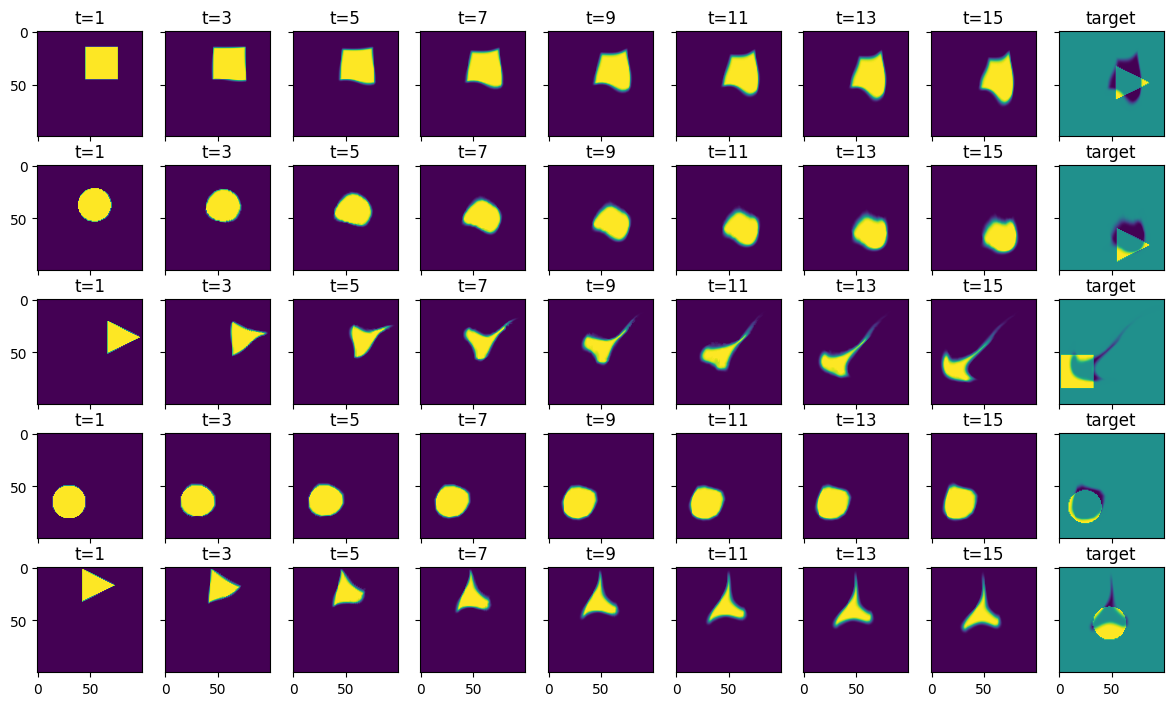

In [26]:
import pylab

target_smokes = [s.get_smoke() for s in shape_t_list[VISU_OFFSET:VISU_NR+VISU_OFFSET]]

pylab.subplots(VISU_NR, 9, sharey='row', sharex='col', figsize=(12, 7))
pylab.tight_layout(w_pad=0)
for i, curr in enumerate(smoke_traj.batch):
    for t in range(9):
        pylab.subplot(VISU_NR, 9, (t+1)+(i*9))
        if t == 8:
            pylab.title('target')
            pylab.imshow(target_smokes[i].values - smoke_traj.batch[i].time[-1].values, origin='upper')
        else:
            pylab.title('t={}'.format(t*2+1))
            pylab.imshow(curr.time[(t*2)+1].values, origin='upper')

<Figure size 1200x500 with 5 Axes>

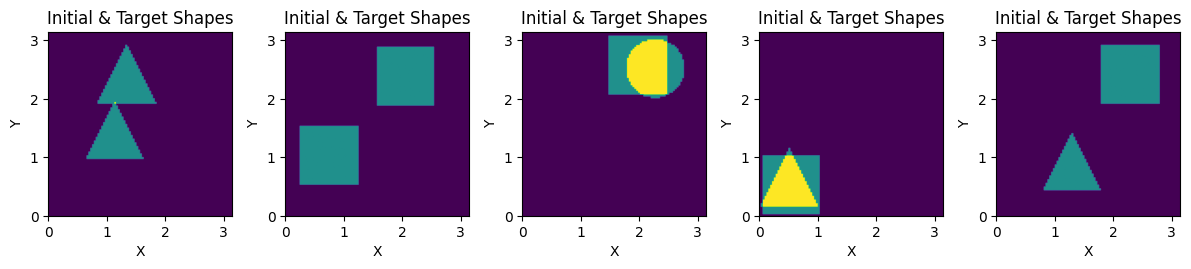

In [27]:
plot({
    "Initial & Target Shapes":
    vis.overlay(
        [s_0.get_smoke() + s_t.get_smoke() for s_0, s_t in zip(shape_0_list[:VISU_NR], shape_t_list[:VISU_NR])],
    )
}
, animate='time', show_color_bar=False)

# Test Generalization of NN on Unseen Data

## Generate Test Data

In [28]:
TEST_SIZE = 5
O = 30
U = 40

def get_points_for_shapes(shape_0, shape_t):
    p_0 = shape_0.get_trivial_points()
    p_t = shape_target.get_trivial_points()
    if O != 0:
        sampler_union = ShapeSampler(shape_0, shape_t, N=O, h1=2, h2=7)
        p_0 = math.concat((p_0, sampler_union.p), instance('i'))
        p_t = math.concat((p_t, sampler_union.p), instance('i'))
    if U != 0:
        sampler_0 = ShapeSampler(shape_0, N=U, h1=3, h2=11)
        sampler_t = ShapeSampler(shape_t, N=U, h1=3, h2=11)
        # Concatenate both the union and non-union points
        p_0 = math.concat((p_0, sampler_0.p), instance('i'))
        p_t = math.concat((p_t, sampler_t.p), instance('i'))
        
    p_0 = shape_0.create_points(p_0)
    p_t = shape_target.create_points(p_t)
    
    return (p_0, p_t)

# Generate test data
p_0_test_list = []
p_t_test_list = []
shape_0_test_list = []
shape_t_test_list = []
for i in range(TEST_SIZE):
    # Circle / Square / Triangle
    Shape_0 = [Circle, Square, Triangle][np.random.randint(3)]
    Shape_target = [Circle, Square, Triangle][np.random.randint(3)]
    # Random positions [0,2] x [0,2]
    shape_0 = Shape_0(pos=(np.random.rand()*2, np.random.rand()*2))
    shape_target = Shape_target(pos=(np.random.rand()*2, np.random.rand()*2))
    
    shape_0_test_list.append(shape_0)
    shape_t_test_list.append(shape_target)
    p_0, p_t = get_points_for_shapes(shape_0, shape_target)
    p_0_test_list.append(p_0)
    p_t_test_list.append(p_t)

    
p_0_test = math.stack(p_0_test_list, batch(batch=TEST_SIZE))
p_t_test = math.stack(p_t_test_list, batch(batch=TEST_SIZE))

# Generate transition data
p_test_trajectory = math.tensor([p_0_test+(p_t_test - p_0_test)/STEPS*t for t in range(STEPS)], batch('time') & p_0_test.shape)

## Run Tests (Performance on Unseen Data)

In [29]:
loss, test_traj, _ = loss_function(
                    p_test_trajectory.time[0:STEPS-1],
                    p_test_trajectory.time[1:STEPS],
                    math.stack([eigenfluid.w]*TEST_SIZE, batch('batch'))
                )
print("Performance on previously unseen, randomly generated test data. (N={}, t={}, O={}, U={}, T={})".format(
        N, STEPS, O, U, str(5)
))
print("Loss = {}".format(loss))
test_traj = math.stack(test_traj, batch('time'))

p_vis = stack([test_traj.batch[:VISU_NR], p_t_test.batch[:VISU_NR]], instance("points"))
COLOR = wrap(['blue', 'red'], instance("points"))

plot(
    PointCloud(p_vis, bounds=DOMAIN), 
    color = COLOR,
    animate='time'
)

Performance on previously unseen, randomly generated test data. (N=16, t=16, O=30, U=40, T=5)
Loss = (40.351, 7.891, 13.980, 21.202, 40.053) along batchᵇ


<Figure size 640x480 with 0 Axes>

## Visualize Grid-Based Smoke Simulation

In [30]:
loss, test_traj, w_traj = loss_function(
                    p_test_trajectory.time[0:STEPS-1],
                    p_test_trajectory.time[1:STEPS],
                    math.stack([eigenfluid.w]*TEST_SIZE, batch('batch')),
                )

trajectory_w = math.stack(w_traj, batch('time'))

smoke_test_traj = []

# Simulate smoke
for b in range(TEST_SIZE):
    curr_smoke_traj = []
    smoke = shape_0_test_list[b].get_smoke()
    curr_smoke_traj.append(smoke)
    for i in range(STEPS-1):
        velocity = eigenfluid.reconstruct_velocity(trajectory_w.batch[b].time[i], N)
        # Simulate
        smoke = advect.mac_cormack(curr_smoke_traj[-1], velocity, dt=DT)
        # Save trajectory
        curr_smoke_traj.append(smoke)
    curr_smoke_traj = math.stack(curr_smoke_traj, batch('time'))
    smoke_test_traj.append(curr_smoke_traj)

smoke_test_traj = math.stack(smoke_test_traj, batch('batch'))

plot(
    vis.overlay(
        smoke_test_traj,
        PointCloud(p_t_test, bounds=DOMAIN)
    ),
    color="red",
    animate='time', 
    show_color_bar=False)

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/site-packages/matplotlib/image.py:702: SyntaxWarning: Automatic conversion of Φ-Flow tensors to NumPy can cause problems because the dimension order is not guaranteed.
  self._A = cbook.safe_masked_invalid(A, copy=True)


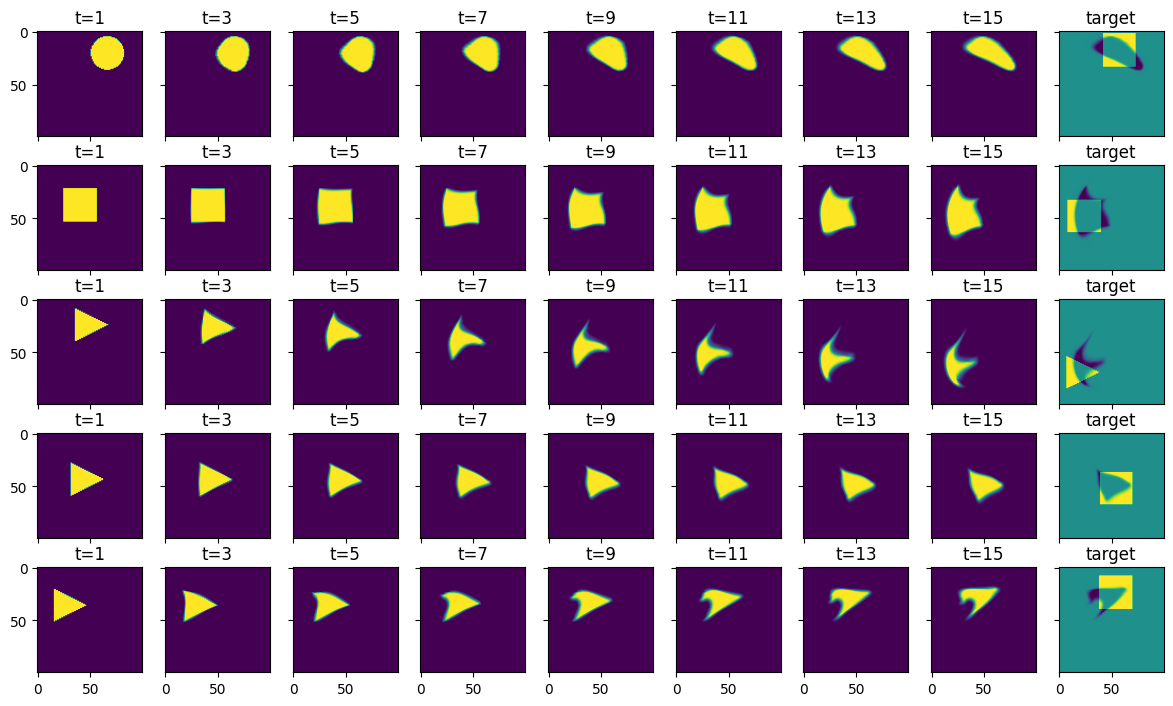

In [31]:
target_smokes_test = [s.get_smoke() for s in shape_t_test_list]

pylab.subplots(VISU_NR, 9, sharey='row', sharex='col', figsize=(12, 7))
pylab.tight_layout(w_pad=0)
for i, curr in enumerate([smoke_test_traj.values.batch[b] for b in range(VISU_NR)]):
    for t in range(9):
        pylab.subplot(VISU_NR, 9, (t+1)+(i*9))
        if t == 8:
            pylab.title('target')
            pylab.imshow(target_smokes_test[i].values - smoke_test_traj.batch[i].time[-1].values, origin='upper')
        else:
            pylab.title('t={}'.format(t*2+1))
            pylab.imshow(curr.time[(t*2)+1], origin='upper')